# AIN313 - Machine Learning Lab.

**Assignment 1**

**Diesase Detection on X-Ray Images**

**Instructor: **Erkut Erdem

**TA:** Sibel Kapan


## Student Information

Please fill the informations!

Name Surname: Alihan Sağöz

Student ID: 21993035

In [1]:
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from random import shuffle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
img_size = 32 #img size
thickness_value = 1 #thicknes_value for contour finding
quality=['covid', 'normal','pneumonia'] 


In [4]:
class K_Nearest_Neighbors_Classifier() :  

  def __init__( self, K ) :    #initalize the class
    self.K = K

  def fit( self, X_train, Y_train ) : #fits the train data to class

    self.X_train = X_train      
    self.Y_train = Y_train
    self.m, self.n = X_train.shape     

  def predict( self, X_test, Weighted = False) : #predicts according to train data and variable that if that weighted or not.
    self.X_test = X_test
    self.Weighted = Weighted
    self.m_test, self.n = X_test.shape
    Y_predict = np.zeros( self.m_test )

    for i in range( self.m_test ) :
      x = self.X_test[i]
      neighbors = np.zeros( self.K )
      distances , neighbors = self.find_neighbors( x ) #finding neighbors and returns two sized array neighbors class and distances.
      if self.Weighted == False :
        Y_predict[i] = mode( neighbors )[0][0]     #if weighted is false returns mod class of neighbors
      else: #if weighted is true 
        freq1 = 0 # weighted sum of group 0 
        freq2 = 0 # weighted sum of group 1 
        freq3 = 0 # weighted sum of group 1 
        for d in range(len(neighbors)): #takes neighbors distance and calculates their weights according to weighted knn algorithm 
          distance = distances[0] 
          if neighbors[d] == 0:
            freq1 += (1 / distance)
          elif neighbors[d] == 1:
            freq2 += (1 / distance)
          elif neighbors[d] == 2:
            freq3 += (1 / distance)
          weight = freq1 + freq2 + freq3
          freq1 = freq1/weight
          freq2 = freq2/weight
          freq3 = freq3/weight
          if max([freq1, freq2, freq3]) == freq1: #if weighted sum of group 0 equals the maximum of all weighted sums.
            Y_predict[i] = 0    #returns 0
          elif max([freq1, freq2, freq3]) == freq2: #if weighted sum of group 1 equals the maximum of all weighted sums.
            Y_predict[i] = 1    #returns 1
          elif max([freq1, freq2, freq3]) == freq3: #if weighted sum of group 2 equals the maximum of all weighted sums.
            Y_predict[i] = 2    #returns 2
    return Y_predict
                  
  def find_neighbors( self, x ) : #finds all neighbors and distances and sorts them. according to k value of knn takes the first k neighbors and returns distances, and their class

    euclidean_distances = np.zeros( self.m )  
    for i in range( self.m ) :
      d = self.euclidean( x, self.X_train[i] )
      euclidean_distances[i] = d

    inds = euclidean_distances.argsort()
    distances = sorted(euclidean_distances[:self.K])
    Y_train_sorted = self.Y_train[inds]
    return distances , Y_train_sorted[:self.K]
      
              
  def euclidean( self, x, x_train ) : #euclidean distance formula
    return np.sqrt( np.sum( np.square( x - x_train ) ) )
        

In [5]:
def imshow(title="Image", image=None, size=8): #for showing images 
  w, h = image.shape[0], image.shape[1]
  aspect_ratio = w / h
  plt.figure(figsize=(size * aspect_ratio, size))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title(title)
  plt.show()

In [6]:
def image_process(img = None, Canny = True , Gabor = True , Noise = True): #takes image and returning array that consist of filtered photos. In here for example returns noise removed, canny, gabor images in array 
  img = cv2.resize(img,(img_size,img_size))
  features = []
  imgNoise = denoise(img)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  cannyimage = canny(img)
  gaborimage = gabor(img)
  if(Canny):
    features.append(cannyimage)
  if(Gabor):
    features.append(gaborimage)
  if(Noise):
    features.append(imgNoise)


  return features

def denoise(img = None): #noise removing
  img = cv2.fastNlMeansDenoisingColored(img, None, 11, 6, 7, 21)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

def findcontour(img = None): #contour finding
  _, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  contours, hierarchy = cv2.findContours(th2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(img, contours, -1, (0,255,0), thickness = thickness_value)
  return img

def canny(img = None):
  edges = cv2.Canny(img,50,135)
  return edges

def gabor(img = None):
  g_kernel = cv2.getGaborKernel((21, 21), 8.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
  filtered_img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)
  return filtered_img

In [7]:
def load_covid_normal_pnueumonia(): #for loading training data from directory to here.
  X,Y=[],[]
  z=[]
  for cata in tqdm(os.listdir(r'drive/MyDrive/chest_xray/train')):
    path_main=os.path.join(r'drive/MyDrive/chest_xray/train',cata)
    if quality[0] in cata:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,0])
    elif quality[1] in cata:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,1])
    else:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,2])

  print('Shuffling your data.....')
  shuffle(z)
  for images, labels in tqdm(z):
    X.append(images);Y.append(labels)
  return X,Y

In [8]:
def load_test_covid_normal_pnueumonia(): #for loading test data from directory to here.
  X,Y=[],[]
  z=[]
  for cata in tqdm(os.listdir(r'drive/MyDrive/chest_xray/test')):
    path_main=os.path.join(r'drive/MyDrive/chest_xray/test',cata)
    if quality[0] in cata:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,0])
    elif quality[1] in cata:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,1])
    else:
      for img_name in os.listdir(path_main):
        img=cv2.imread(os.path.join(path_main,img_name))
        img=cv2.resize(img,(img_size,img_size))
        z.append([img,2])
  print('Shuffling your data.....')
  shuffle(z)
  for images, labels in tqdm(z):
    X.append(images);Y.append(labels)
  return X,Y

In [9]:
X, Y = load_covid_normal_pnueumonia() 

100%|██████████| 3/3 [02:14<00:00, 44.92s/it]


Shuffling your data.....


100%|██████████| 3000/3000 [00:00<00:00, 730672.55it/s]


In [10]:
X_t, Y_t = load_test_covid_normal_pnueumonia()

100%|██████████| 3/3 [00:15<00:00,  5.07s/it]


Shuffling your data.....


100%|██████████| 300/300 [00:00<00:00, 704136.09it/s]


In [11]:
data = {'Size': [],
        'Weighted':  [],
        'K value': [],
        'Canny': [],
        'Gabor': [],
        'NoiseRemoving': [],
        'Accuracy': [],
        'Precision':[],
        'Recall':[]
        }
df = pd.DataFrame(data)


In [12]:
def knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False):
  x1 = []  
  xt = []
  for img in X:
    x1.append(image_process(img = img, Canny = Cannyx , Gabor = Gaborx , Noise = Noisex))
  for img in X_t:
    xt.append(image_process(img = img, Canny = Cannyx , Gabor = Gaborx , Noise = Noisex))

  X_train = np.array(x1) #array to np array
  Y_train = np.array(Y)
  X_test = np.array(xt)
  Y_test = np.array(Y_t)
  le = LabelEncoder()
  Y_train = le.fit_transform(Y_train) #transforms np array to correct version for knn algorithm.
  Y_test = le.fit_transform(Y_test)

  X_train_size = X_train.shape[0]
  X_train = X_train.reshape(X_train_size,-1)
  X_test_size = X_test.shape[0]
  X_test = X_test.reshape(X_test_size,-1)

  model = K_Nearest_Neighbors_Classifier( K = k)   #knn model with k = 3

  model.fit( X_train, Y_train ) #fits the data to knn model
  Y_pred = model.predict( X_test , Weighted = weightedx ) #pred data for knn model
  acc = accuracy_score(Y_test, Y_pred)
  prec = precision_score(Y_test, Y_pred, average='macro')
  recall = recall_score(Y_test, Y_pred, average = 'macro')
  df.loc[len(df.index)] = [img_size, weightedx, k, Cannyx, Gaborx, Noisex, acc, prec, recall] 


In [13]:
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = False) #weighted vs normal
knnFunc(k = 3, Cannyx = True, Gaborx = True, Noisex = True , weightedx = True)


In [14]:
df

,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,32.0,0.0,3.0,1.0,1.0,1.0,0.76,0.791512,0.76
1,32.0,True,3.0,True,True,True,0.74,0.754321,0.74


We determined that knn is working better than weighted

In [15]:
knnFunc(k = 3, Cannyx = True, Gaborx = False, Noisex = True , weightedx = False) #best option
knnFunc(k = 3, Cannyx = False, Gaborx = True, Noisex = True , weightedx = False)
knnFunc(k = 3, Cannyx = False, Gaborx = False, Noisex = True , weightedx = False)


In [16]:
df 

,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,32.0,0.0,3.0,1.0,1.0,1.0,0.760000,0.791512,0.760000
1,32.0,True,3.0,True,True,True,0.740000,0.754321,0.740000
2,32.0,False,3.0,True,False,True,0.790000,0.818956,0.790000
3,32.0,False,3.0,False,True,True,0.760000,0.791512,0.760000
4,32.0,False,3.0,False,False,True,0.793333,0.821225,0.793333


We determined that canny :true, gabor : false, noise :true gives best accuracy in this case 

In [17]:
knnFunc(k = 5, Cannyx = True, Gaborx = False, Noisex = True , weightedx = False) # best k
knnFunc(k = 7, Cannyx = True, Gaborx = False, Noisex = True , weightedx = False)
knnFunc(k = 9, Cannyx = True, Gaborx = False, Noisex = True , weightedx = False)


In [18]:
df

,Size,Weighted,K value,Canny,Gabor,NoiseRemoving,Accuracy,Precision,Recall
0,32.0,0.0,3.0,1.0,1.0,1.0,0.760000,0.791512,0.760000
1,32.0,True,3.0,True,True,True,0.740000,0.754321,0.740000
2,32.0,False,3.0,True,False,True,0.790000,0.818956,0.790000
3,32.0,False,3.0,False,True,True,0.760000,0.791512,0.760000
4,32.0,False,3.0,False,False,True,0.793333,0.821225,0.793333
5,32.0,False,5.0,True,False,True,0.800000,0.824438,0.800000
6,32.0,False,7.0,True,False,True,0.803333,0.831740,0.803333
7,32.0,False,9.0,True,False,True,0.786667,0.818654,0.786667


 in this case k=7 is working just fine

Now we will operate with 64x64 with the best options we find upstairs.

In [19]:
img_size = 64


In [20]:
X, Y = load_covid_normal_pnueumonia() 


100%|██████████| 3/3 [00:58<00:00, 19.48s/it]


Shuffling your data.....


100%|██████████| 3000/3000 [00:00<00:00, 1003102.04it/s]


In [21]:
X_t, Y_t = load_test_covid_normal_pnueumonia()

100%|██████████| 3/3 [00:08<00:00,  2.86s/it]


Shuffling your data.....


100%|██████████| 300/300 [00:00<00:00, 665762.54it/s]


In [22]:
x1 = []
xt = []
for img in X:
  x1.append(image_process(img = img, Canny = True , Gabor = False , Noise = True))
for img in X_t:
  xt.append(image_process(img = img, Canny = True , Gabor = False , Noise = True))

In [23]:
X_train = np.array(x1) #array to np array
Y_train = np.array(Y)
X_test = np.array(xt)
Y_test = np.array(Y_t)

In [24]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train) #transforms np array to correct version for knn algorithm.
Y_test = le.fit_transform(Y_test)

X_train_size = X_train.shape[0]
X_train = X_train.reshape(X_train_size,-1)
X_test_size = X_test.shape[0]
X_test = X_test.reshape(X_test_size,-1)

In [25]:
print(X_train.shape)
X_train

(3000, 8192)


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,  24,  24,  24],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 255,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [255, 255, 255, ..., 215, 213, 213]], dtype=uint8)

In [26]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
model = K_Nearest_Neighbors_Classifier( K = 7)   #knn model with k = 7
model.fit( X_train, Y_train ) #fits the data to knn model
Y_pred = model.predict( X_test , Weighted = False ) #pred data for knn model


In [27]:
cm = metrics.confusion_matrix(Y_test,Y_pred)

In [28]:
cm_df = pd.DataFrame(cm,
                     index = quality, 
                     columns = quality)

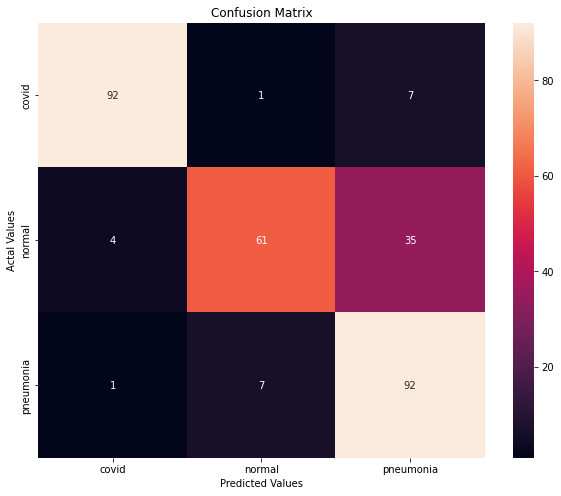

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In this matrix we can say that our model is close to predict that the normal patient as pneumonia.The rest of the predicts worked just fine

In [30]:
print(metrics.classification_report(Y_pred,Y_test))

              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93        97
         1.0       0.61      0.88      0.72        69
         2.0       0.92      0.69      0.79       134

    accuracy                           0.82       300
   macro avg       0.82      0.84      0.81       300
weighted avg       0.85      0.82      0.82       300



In [31]:
false_predicted = []
for i in range(len(Y_test)):
  if Y_test[i] != Y_pred[i]:
    false_predicted.append(i)

In [32]:
print(false_predicted) #these are wrong predicted indexes lets take a few examples and look at [47,85,155]

[13, 21, 31, 38, 44, 46, 48, 57, 62, 63, 74, 79, 84, 87, 91, 102, 104, 110, 112, 116, 127, 130, 135, 145, 148, 149, 156, 159, 166, 167, 172, 178, 179, 183, 184, 192, 202, 204, 209, 225, 227, 230, 238, 245, 250, 252, 258, 260, 264, 269, 276, 289, 292, 298, 299]


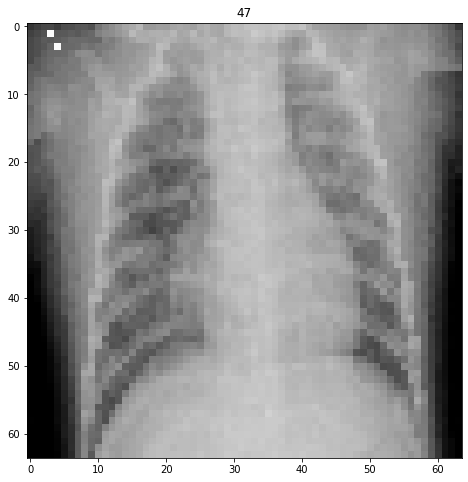

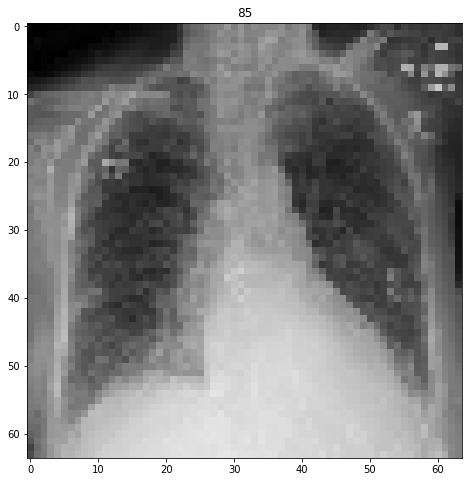

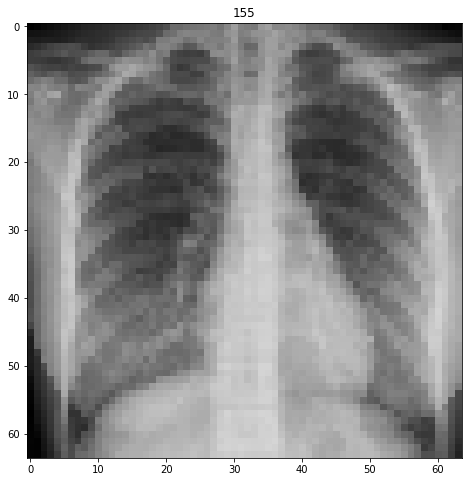

In [33]:
imshow("47",X_t[47])
imshow("85",X_t[85])
imshow("155",X_t[155])

As you can see in photos there are certain black and whites that does not fit the rest of the foto. I can say that because of cables on the photos are breaking the photo thats why
our model fail to understand about what they are and thinks that all of them are relevant but it is not. As a solution we could use different methods that works better of computer vision or we can get rid of the cables one by one with manuel. 